In [80]:
from elasticsearch7 import Elasticsearch
#ignore warning
import warnings
warnings.filterwarnings("ignore")


class RankList:

    def __init__(self):
        self.es = Elasticsearch(cloud_id= "6200:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvOjQ0MyRiZTllZjE5NDRkNTg0MDE3YTU0NDg0MzcwYjk5MjQzMSQ2Zjg1ODJhNWRjMGY0NDBhODU1Njk1MDQ4NzMyNmU2Yg==",
                        http_auth=("elastic", "fwOhKti7myB3PKFHQavQBhcr"))
        self.queries = {
        'West African Ebola epidemic': 152901,
        'H1N1 Swine Flu pandemic': 152902,
        'COVID 19': 152903
        }
        self.ranked_list = {
            152901: [],
            152902: [],
            152903: []
        }
        if self.es.ping():
            print("Connected to Elasticsearch!")
        else:
            print("Could not connect to Elasticsearch!")

    def create_rank_list(self):
        for i, query in enumerate(self.queries):
            print("Reading ranked list: " + str(i + 1))
            query_id = self.queries[query]
            print("Querying Elasticsearch for query: " + query)

            response = self.es.search(index="crawler",
                                  body={
                                      "size": 200,
                                      "query": {
                                          "multi_match": {
                                            "query": query,
                                            "fields": ["title", "content"]
                                        }
                                      },
                                      "_source": ""
                                  })['hits']['hits']
            for item in response:
                self.ranked_list[query_id].append({item['_id']: item['_score']})

        with open("ranked_list.txt", "w", encoding="utf-8") as f:
            for query_id  in self.ranked_list:
                for idx, item in enumerate(self.ranked_list[query_id]):
                    for url in item:
                        line = '{0} Q0 {1} {2} {3} Exp\n'.format(query_id, url, idx + 1, str(item[url]))
                        f.write(line)
        print("Rank list created successfully!")

my_es = RankList()
my_es.create_rank_list()

Connected to Elasticsearch!
Reading ranked list: 1
Querying Elasticsearch for query: West African Ebola epidemic
Reading ranked list: 2
Querying Elasticsearch for query: H1N1 Swine Flu pandemic
Reading ranked list: 3
Querying Elasticsearch for query: COVID 19
Rank list created successfully!


In [95]:
import matplotlib.pyplot as plt
import math

class TrecEval:
    def __init__(self, qrel_file, ranked_file, print_all_queries= True, plot_graph=True, use_map=True):
        self.qrel = {}
        self.qrel_raw = {}
        self.num_rel = {}
        self.trec = {}
        self.recalls = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        self.cutoffs = [5, 10, 15, 20, 30, 100]
        self.rating_map = {'Very relevant': 1, 'Relevant': 1, 'Non-relevant': 0}
        self.print_all_queries = print_all_queries
        self.qrel_file = qrel_file
        self.ranked_file = ranked_file
        self.plot_graph = plot_graph
        self.use_map = use_map

    def read_qrel(self):
        with open(self.qrel_file, "r") as f:
            for line in f.readlines():
                query_id, _, doc_id, rating_score = line.strip().split(maxsplit=3)
                if self.use_map:
                    rating_score = self.rating_map[rating_score]
                else:
                    rating_score = int(rating_score)
                if query_id in self.qrel:
                    self.qrel[query_id][doc_id] = rating_score
                else:
                    self.qrel[query_id] = {}
                    self.qrel[query_id][doc_id] = rating_score

                if query_id in self.num_rel:
                    self.num_rel[query_id] += rating_score
                else:
                    self.num_rel[query_id] = 0
                    self.num_rel[query_id] += rating_score

    def read_trec(self):
        with open(self.ranked_file, "r") as f:
            for line in f.readlines():
                query_id, _, doc_id, _, score, _ = line.split(" ")
                score = float(score)
                if query_id in self.trec:
                    self.trec[query_id][doc_id] = score
                else:
                    self.trec[query_id] = {}
                    self.trec[query_id][doc_id] = score

    def calculate_metrics(self):
        self.read_trec()
        self.read_qrel()

        total_num_ret = 0
        total_num_rel = 0
        total_num_rel_ret = 0
        num_queries = 0
        sum_prec_at_cutoffs = {}
        sum_prec_at_recalls = {}
        sum_avg_prec = 0
        sum_r_prec = 0
        avg_prec_at_cutoffs = {}
        avg_prec_at_recalls = {}
        for query_id in sorted(self.trec.keys(), key=int):
            if self.num_rel[query_id] == 0:
                continue

            num_queries += 1

            prec_list = {}
            rec_list = {}

            num_ret = 0
            num_rel_ret = 0
            sum_prec = 0

            for doc_id in sorted(self.trec[query_id], key=lambda x: (self.trec[query_id].get(x), x), reverse=True):
                num_ret += 1
                if doc_id in self.qrel[query_id]:
                    rel = self.qrel[query_id][doc_id]
                else:
                    rel = 0
                if rel:
                    sum_prec += rel * (1.0 + num_rel_ret) / num_ret
                    num_rel_ret += rel

                prec_list[num_ret] = num_rel_ret / num_ret
                rec_list[num_ret] = num_rel_ret / self.num_rel[query_id]
                if num_ret >= 1000:
                    break

            if self.plot_graph:
                plt.figure()
                x = [rec_list[i] for i in rec_list]
                y = [prec_list[i] for i in prec_list]
                plt.plot(x, y, '-')
                plt.ylabel("Precision")
                plt.xlabel("Recall")
                plt.title("Precision-Recall Plot, Query ID: {}".format(query_id))
                plt.show()

            avg_prec = sum_prec / self.num_rel[query_id]

            final_recall = num_rel_ret / self.num_rel[query_id]
            i = num_ret + 1
            while i <= 1000:
                prec_list[i] = num_rel_ret / i
                rec_list[i] = final_recall
                i += 1

            prec_at_cutoffs = {}
            for cutoff in self.cutoffs:
                prec_at_cutoffs[cutoff] = prec_list[cutoff]

            if self.num_rel[query_id] > num_ret:
                r_prec = num_rel_ret / self.num_rel[query_id]
            else:
                int_num_rel = int(self.num_rel[query_id])
                frac_num_rel = self.num_rel[query_id] - int_num_rel

                if frac_num_rel > 0:
                    r_prec = (1 - frac_num_rel) * prec_list[int_num_rel] + frac_num_rel * prec_list[int_num_rel + 1]
                else:
                    r_prec = prec_list[int_num_rel]

            max_prec = 0
            for i in reversed(range(1, 1001)):
                if prec_list[i] > max_prec:
                    max_prec = prec_list[i]
                else:
                    prec_list[i] = max_prec

            prec_at_recalls = {}
            i = 1
            for recall in self.recalls:
                while i <= 1000 and rec_list[i] < recall:
                    i += 1
                if i <= 1000:
                    prec_at_recalls[recall] = prec_list[i]
                else:
                    prec_at_recalls[recall] = 0

            if self.print_all_queries:
                self.print_metrics(query_id, num_ret, self.num_rel[query_id], num_rel_ret, prec_at_recalls, avg_prec,
                                prec_at_cutoffs, r_prec)

            total_num_ret += num_ret
            total_num_rel += self.num_rel[query_id]
            total_num_rel_ret += num_rel_ret

            for cutoff in self.cutoffs:
                if cutoff in sum_prec_at_cutoffs:
                    sum_prec_at_cutoffs[cutoff] += prec_at_cutoffs[cutoff]
                else:
                    sum_prec_at_cutoffs[cutoff] = 0
                    sum_prec_at_cutoffs[cutoff] += prec_at_cutoffs[cutoff]
            for recall in self.recalls:
                if recall in sum_prec_at_recalls:
                    sum_prec_at_recalls[recall] += prec_at_recalls[recall]
                else:
                    sum_prec_at_recalls[recall] = 0
                    sum_prec_at_recalls[recall] += prec_at_recalls[recall]
            sum_avg_prec += avg_prec
            sum_r_prec += r_prec

        for cutoff in self.cutoffs:
            avg_prec_at_cutoffs[cutoff] = sum_prec_at_cutoffs[cutoff] / num_queries
        for recall in self.recalls:
            avg_prec_at_recalls[recall] = sum_prec_at_recalls[recall] / num_queries

        mean_avg_prec = sum_avg_prec / num_queries
        avg_r_prec = sum_r_prec / num_queries

        self.print_metrics(num_queries, total_num_ret, total_num_rel, total_num_rel_ret, avg_prec_at_recalls, mean_avg_prec,
                        avg_prec_at_cutoffs, avg_r_prec)

    def compute_ndcg(self, rank):
        self.read_trec()

        for query_id in self.trec:
            i = 1
            cumulative_gain = 0
            ordering = {}
            for doc in self.trec[query_id]:
                if doc in self.qrel[query_id]:
                    rel = self.qrel[query_id][doc]
                else:
                    rel = 0
                ordering[doc] = rel
                gain = 2 ** rel - 1
                discount = 1 / (math.log(1 + i))
                cumulative_gain += gain * discount
                if i == rank:
                    break
                else:
                    i += 1
            ideal_ordering = {key: ordering[key] for key in sorted(ordering, key=ordering.get, reverse=True)}
            ideal_cumulative_gain = 0
            for idx, doc in enumerate(ideal_ordering):
                gain = 2 ** ideal_ordering[doc] - 1
                discount = 1 * (math.log(1 + idx + 1))
                ideal_cumulative_gain += gain / discount
            ndcg = cumulative_gain / ideal_cumulative_gain
            print("Query ID: {} nDCG: {:.4f} At rank: {}".format(query_id, ndcg, rank))

    def print_metrics(self, query_id, num_ret, num_rel, num_rel_ret, prec_at_recalls, avg_prec, prec_at_cutoffs, r_prec):
        print("Queryid (Num):     {}".format(query_id))
        print("Total number of documents over all queries")
        print("    Retrieved:    {}".format(num_ret))
        print("    Relevant:     {:.0f}".format(num_rel))
        print("    Rel_ret:      {:.0f}".format(num_rel_ret))
        print("Interpolated Recall - Precision Averages:")
        for p in prec_at_recalls:
            print("    at {:.2f}       {:.4f}".format(p, prec_at_recalls[p]))
        print("Average precision (non-interpolated) for all rel docs(averaged over queries)")
        print("                  {:.4f}".format(avg_prec))
        print("Precision:")
        for p in prec_at_cutoffs:
            print("  At {:4} docs:   {:.4f}".format(p, prec_at_cutoffs[p]))
        print("R-Precision (precision after R (= num_rel for a query) docs retrieved):")
        print("    Exact:        {:.4f}".format(r_prec))
        print("")

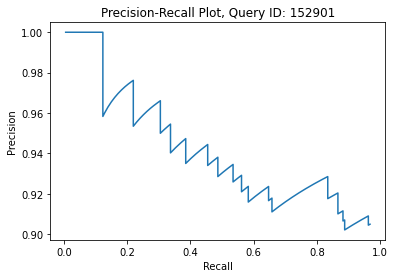

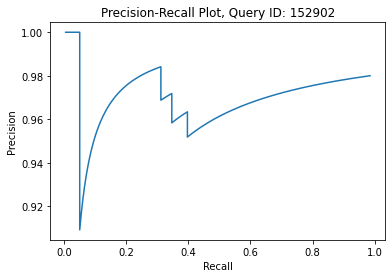

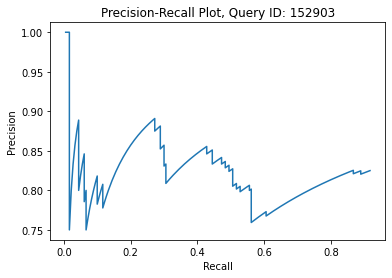

Queryid (Num):     3
Total number of documents over all queries
    Retrieved:    600
    Relevant:     566
    Rel_ret:      542
Interpolated Recall - Precision Averages:
    at 0.00       1.0000
    at 0.10       0.9583
    at 0.20       0.9504
    at 0.30       0.9358
    at 0.40       0.9267
    at 0.50       0.9140
    at 0.60       0.9113
    at 0.70       0.9113
    at 0.80       0.9113
    at 0.90       0.9047
    at 1.00       0.0000
Average precision (non-interpolated) for all rel docs(averaged over queries)
                  0.8745
Precision:
  At    5 docs:   0.9333
  At   10 docs:   0.9333
  At   15 docs:   0.9111
  At   20 docs:   0.9167
  At   30 docs:   0.9111
  At  100 docs:   0.9100
R-Precision (precision after R (= num_rel for a query) docs retrieved):
    Exact:        0.9001

Query ID: 152901 nDCG: 1.0000 At rank: 10
Query ID: 152902 nDCG: 1.0000 At rank: 10
Query ID: 152903 nDCG: 0.9667 At rank: 10


In [108]:
# Example usage:
my_trec = TrecEval("qrel.txt", "ranked_list.txt", print_all_queries=False, plot_graph= True, use_map = True)
my_trec.calculate_metrics()
my_trec.compute_ndcg(10)

In [107]:
rating_map = {'Very relevant': 1, 'Relevant': 1, 'Non-relevant': 0}
with open("qrel.txt", "r") as f:
    with open("qrel_mod.txt", "w") as f2:
        for line in f.readlines():
            query_id, _, doc_id, rating_score = line.strip().split(maxsplit=3)
            rating_score = rating_map[rating_score]
            f2.write("{0} 0 {1} {2}\n".format(query_id, doc_id, rating_score))

print("Crawler with ES Retrieval Model")
!perl trec_eval.pl qrel_mod.txt ranked_list.txt

Crawler with ES Retrieval Model
Error due to 3

Queryid (Num):        3
Total number of documents over all queries
    Retrieved:      600
    Relevant:       566
    Rel_ret:        542
Interpolated Recall - Precision Averages:
    at 0.00       1.0000
    at 0.10       0.9583
    at 0.20       0.9504
    at 0.30       0.9358
    at 0.40       0.9267
    at 0.50       0.9140
    at 0.60       0.9113
    at 0.70       0.9113
    at 0.80       0.9113
    at 0.90       0.9047
    at 1.00       0.0000
Average precision (non-interpolated) for all rel docs(averaged over queries)
                  0.8745
Precision:
  At    5 docs:   0.9333
  At   10 docs:   0.9333
  At   15 docs:   0.9111
  At   20 docs:   0.9167
  At   30 docs:   0.9111
  At  100 docs:   0.9100
  At  200 docs:   0.9033
  At  500 docs:   0.3613
  At 1000 docs:   0.1807
R-Precision (precision after R (= num_rel for a query) docs retrieved):
    Exact:        0.9001


In [101]:
my_trec = TrecEval("qrels.adhoc.51-100.AP89.txt", "results_ES.txt", print_all_queries=False, plot_graph= False, use_map = False)
my_trec.calculate_metrics()

Queryid (Num):     25
Total number of documents over all queries
    Retrieved:    25000
    Relevant:     1832
    Rel_ret:      1319
Interpolated Recall - Precision Averages:
    at 0.00       0.7125
    at 0.10       0.5369
    at 0.20       0.4596
    at 0.30       0.3748
    at 0.40       0.3240
    at 0.50       0.2838
    at 0.60       0.2426
    at 0.70       0.2161
    at 0.80       0.1694
    at 0.90       0.0766
    at 1.00       0.0249
Average precision (non-interpolated) for all rel docs(averaged over queries)
                  0.2930
Precision:
  At    5 docs:   0.4480
  At   10 docs:   0.4280
  At   15 docs:   0.3947
  At   20 docs:   0.3800
  At   30 docs:   0.3627
  At  100 docs:   0.2424
R-Precision (precision after R (= num_rel for a query) docs retrieved):
    Exact:        0.3186



In [105]:
print("ES Retrieval Model")
!perl trec_eval.pl qrels.adhoc.51-100.AP89.txt results_ES.txt

ES Retrieval Model
Error due to 25

Queryid (Num):       25
Total number of documents over all queries
    Retrieved:    25000
    Relevant:      1832
    Rel_ret:       1319
Interpolated Recall - Precision Averages:
    at 0.00       0.7125
    at 0.10       0.5369
    at 0.20       0.4596
    at 0.30       0.3748
    at 0.40       0.3240
    at 0.50       0.2838
    at 0.60       0.2426
    at 0.70       0.2161
    at 0.80       0.1694
    at 0.90       0.0766
    at 1.00       0.0249
Average precision (non-interpolated) for all rel docs(averaged over queries)
                  0.2930
Precision:
  At    5 docs:   0.4480
  At   10 docs:   0.4280
  At   15 docs:   0.3947
  At   20 docs:   0.3800
  At   30 docs:   0.3627
  At  100 docs:   0.2424
  At  200 docs:   0.1704
  At  500 docs:   0.0933
  At 1000 docs:   0.0528
R-Precision (precision after R (= num_rel for a query) docs retrieved):
    Exact:        0.3186
